<img style="float: left;" src="resources/made.jpg" width="35%" height="35%">

# Академия MADE
## Семинар 1: PyTorch recap / аугментация / OpenCV
Иван Карпухин, ведущий программист-исследователь команды машинного зрения

<div style="clear:both;"></div>

Семинар состоит из двух частей. В первой мы применим классические методы регуляризации. Во второй сделаем аугментацию данных средствами OpenCV.

Для выполнения работы нужны следующие пакеты (Python 3):
* opencv-python
* torch
* torchvision
* albumentations

Установить их можно командой:
```bash
pip3 install --user opencv-python torch torchvision albumentations
```

In [25]:
%matplotlib inline
import random

import albumentations
import cv2
import torch
import torchvision
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image

import cvmade
import seminar

print(torch.__version__)

# Параметры тренировки.
USE_CUDA = torch.cuda.is_available()
if USE_CUDA:
    print("Use CUDA")


TRAIN = True

TRAIN_KWARGS = {"plot": True,
                "train_plot_kwargs": {"c": "b"},
                "test_scatter_kwargs": {"c": "y", "s": 100, "zorder": 1e10},
                "use_cuda": USE_CUDA}

1.7.1
Use CUDA


# Простая тренировка на CIFAR-10.

## Подготовка данных

Если возникнут трудности при загрузке данных, можно скачать архив по ссылке и самостоятельно распаковать в папку с ноутбуком, так, чтобы рядом с ноутбуком появилась папка cifar-10-batches-py.

Ссылка с данными (если не заработает автоскачивание): https://cloud.mail.ru/public/2ku1/KJPEsJ6xR

Files already downloaded and verified
Files already downloaded and verified
Single image shape (CHW): [3, 32, 32]
Trainset size: 50000
Testset size: 10000
Trainset


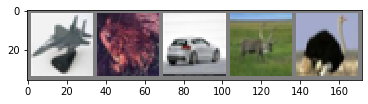

Testset


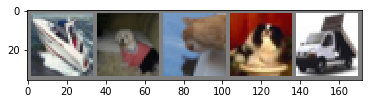

In [2]:
from torchvision.datasets import CIFAR10

DATA_ROOT = "."

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),  # Преобразовать PIL изображения в Torch тензоры.
    torchvision.transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])
trainset = CIFAR10(DATA_ROOT, train=True, download=True, transform=transform)
testset = CIFAR10(DATA_ROOT, train=False, download=True, transform=transform)
print("Single image shape (CHW):", list(testset[0][0].shape))
print("Trainset size:", len(trainset))
print("Testset size:", len(testset))

print("Trainset")
cvmade.plot.torch.show_images_dataset(trainset)
print("Testset")
cvmade.plot.torch.show_images_dataset(testset)

## Создание модели

Создадим сеть вида VGG (Сокращение от Visual Geometry Group, https://arxiv.org/pdf/1409.1556.pdf ).

Сеть VGG состоит из сверток 3x3, ReLU, max pooling и полносвязных слоев. Оригинальная сеть VGG применялась к изображениям 224x224, мы же применяем к изображениям 32x32. В статье описаны варианты сети VGG с количеством слоев от 11 до 19. Для задачи CIFAR10 достаточно меньшего числа слоев. Итоговая сложность модели позволит нам учить сеть на CPU.

Заметьте, что после pooling слоя площадь изображения уменьшается в 4 раза, а число каналов увеличивается в два раза, т.е. размер тензора уменьшается в два раза. Баланс между размером изображения и числом каналов позволяет сохранить достаточное количество информации при продвижении по сети.

<img src="resources/vgg1.jpg" align="left" hspace="20" width="50%" height="50%"/> 
<img src="resources/vgg2.jpg" align="left" hspace="20" width="50%" height="50%"/>
<div style="clear:both;"></div>

Шпаргалка:

```python
torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')

torch.nn.ReLU(inplace=False)

torch.nn.MaxPool2d(kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)

torch.nn.Linear(in_features, out_features, bias=True)
```

In [3]:
class VGGNetwork(torch.nn.Sequential):        
    def _make_conv3x3(self, in_channels, out_channels):
        # Начало вашего кода.
        
        layer = 
        
        # Конец вашего кода.
        return layer
    
    def _make_relu(self):
        # Начало вашего кода.
        
        layer = 
        
        # Конец вашего кода.
        return layer
    
    def _make_maxpool2x2(self):
        # Начало вашего кода.
        
        layer = 
        
        # Конец вашего кода.
        return layer
    
    def _make_fully_connected(self, in_features, out_features, last=False):
        # Начало вашего кода.
        
        layer = 
        
        # Конец вашего кода.
        return layer
    
    def __init__(self, n_classes=10):
        # Мы используем same padding, чтобы свертки не меняли ширину и высоту тензоров.
        # Ширина и высота меняются только в maxpool (уменьшаются в два раза).
        layers = [
            self._make_conv3x3(in_channels=3, out_channels=32),
            self._make_conv3x3(in_channels=32, out_channels=32),
            self._make_relu(),
            self._make_maxpool2x2(),
            
            self._make_conv3x3(in_channels=32, out_channels=64),
            self._make_conv3x3(in_channels=64, out_channels=64),
            self._make_relu(),
            self._make_maxpool2x2(),
            
            self._make_conv3x3(in_channels=64, out_channels=128),
            self._make_conv3x3(in_channels=128, out_channels=128),
            self._make_relu(),
            self._make_maxpool2x2(),
            
            self._make_conv3x3(in_channels=128, out_channels=256),
            self._make_conv3x3(in_channels=256, out_channels=256),
            self._make_relu(),
            self._make_maxpool2x2(),
            
            torch.nn.modules.Flatten(),  # Преобразовать 4-мерный тензор BHWC в двумерный BD.
            
            self._make_fully_connected(in_features=256 * 2 * 2, out_features=512),
            self._make_fully_connected(in_features=512, out_features=512),
            self._make_fully_connected(in_features=512, out_features=n_classes, last=True)
        ]
        super().__init__(*layers)
        self.initialize_weights()
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
                if m.bias is not None:
                    torch.nn.init.constant_(m.bias, 0)
            elif isinstance(m, torch.nn.BatchNorm2d):
                torch.nn.init.constant_(m.weight, 1)
                torch.nn.init.constant_(m.bias, 0)
            elif isinstance(m, torch.nn.Linear):
                torch.nn.init.normal_(m.weight, 0, 0.01)
                torch.nn.init.constant_(m.bias, 0)
                
def count_parameters(model):
    total = 0
    for p in model.parameters():
        total += np.prod(list(p.shape))
    return total
                
vgg = VGGNetwork()
print(vgg)
print("Total parameters: {}".format(count_parameters(vgg)))

seminar.check_vgg(VGGNetwork)

VGGNetwork(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (14): ReLU()
  (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (16): 

## Обучение

Воспользуемся оптимизацией с моментом Нестерова. Будем использовать момент, равный 0.9 и начальный шаг обучения 0.01.

Шпаргалка:

```python
torch.nn.CrossEntropyLoss(weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='mean')

torch.optim.SGD(params, lr, momentum=0, dampening=0, weight_decay=0, nesterov=False)
```

In [4]:
def make_loss():
    # Ваш код, который создает loss.
    
    loss = 
    
    #
    return loss

def make_optimizer(model):
    # Ваш код, который создает оптимизатор.
    
    optimizer = 
    
    # Конец вашего кода.
    
    return optimizer

seminar.check_loss_fn(make_loss)
seminar.check_optimizer_fn(make_optimizer)

CHECK OK
CHECK OK


Используем экспоненциально затухающий learning rate.

График изменения learning rate:


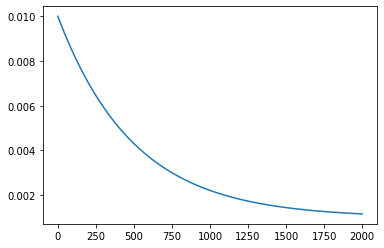

In [5]:
def lr(step):
    return 0.1 + 0.9 * (0.998) ** step

def make_lr_scheduler(optimizer):
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr)

xs = np.linspace(0, 2000)
print("График изменения learning rate:")
plt.plot(xs, 0.01 * lr(xs))
plt.show()

<IPython.core.display.Javascript object>


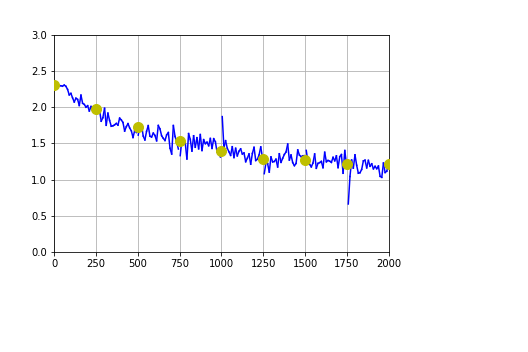

Test loss: 2.302746230316162
Test accuracy: 0.0943
Step 0
Train loss: 2.0424, learning rate: 0.0065         
Test loss: 1.9705081832885742
Test accuracy: 0.2139
Step 250
Train loss: 1.7935, learning rate: 0.0043         
Test loss: 1.7292350706100463
Test accuracy: 0.3523
Step 500
Train loss: 1.5026, learning rate: 0.0030         
Test loss: 1.5298199925422669
Test accuracy: 0.426
Step 750
Train loss: 1.4974, learning rate: 0.0022         
Test loss: 1.3973804892539978
Test accuracy: 0.4752
Step 1000
Train loss: 1.3061, learning rate: 0.0017         
Test loss: 1.284572478199005
Test accuracy: 0.531
Step 1250
Train loss: 1.1786, learning rate: 0.0014         
Test loss: 1.269159652042389
Test accuracy: 0.5435
Step 1500
Train loss: 1.1578, learning rate: 0.0013         
Test loss: 1.2146236213684083
Test accuracy: 0.5602
Step 1750
Train loss: 1.0240, learning rate: 0.0012         
Test loss: 1.213401334667206
Test accuracy: 0.5556


In [9]:
if TRAIN:
    # Разрешить интерактивные графики.
    %matplotlib notebook
    seminar.train_model(vgg, make_loss, make_optimizer, trainset, testset,
                        lr_scheduler_fn=make_lr_scheduler,
                        **TRAIN_KWARGS)
    # Отключить интерактивные графики.
    %matplotlib inline
else:
    %matplotlib inline
    cvmade.plot.show_image("resources/01-simple-train.jpg")

# Batchnorm

Batchnorm ( https://arxiv.org/pdf/1502.03167.pdf ) это техника улучшения сходимости сетей с большим количеством слоёв.

Во время тренировки:

<img src="resources/batchnorm.jpg" align="left" width="40%" height="40%"/> 
<div style="clear:both;"></div>

Во время применения статистики по батчу заменяются на более точные статистики по корпусу данных.

Шпаргалка:

```python
torch.nn.BatchNorm2d(num_features, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
```

In [10]:
class VGGNetworkBN(VGGNetwork):
    @staticmethod
    def _make_conv3x3(in_channels, out_channels):
        # Ваш код, который создает слои сети.
        
        conv_layer = 
        batchnorm_layer = 
        
        # Конец вашего кода.
        return torch.nn.Sequential(conv_layer, batchnorm_layer)
    
vgg_bn = VGGNetworkBN()
print(vgg_bn)
seminar.check_vgg_bn(VGGNetworkBN)

VGGNetworkBN(
  (0): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (5): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

<IPython.core.display.Javascript object>


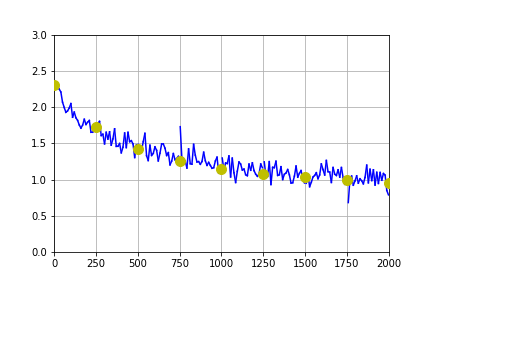

Test loss: 2.302816741943359
Test accuracy: 0.0914
Step 0
Train loss: 1.7277, learning rate: 0.0065         
Test loss: 1.7311202779769896
Test accuracy: 0.3608
Step 250
Train loss: 1.4457, learning rate: 0.0043         
Test loss: 1.4230795461654664
Test accuracy: 0.4534
Step 500
Train loss: 1.2946, learning rate: 0.0030         
Test loss: 1.2514692319869996
Test accuracy: 0.5471
Step 750
Train loss: 1.0622, learning rate: 0.0022         
Test loss: 1.1515563713550567
Test accuracy: 0.5895
Step 1000
Train loss: 1.2075, learning rate: 0.0017         
Test loss: 1.0786015755176543
Test accuracy: 0.6178
Step 1250
Train loss: 1.1118, learning rate: 0.0014         
Test loss: 1.0412259100914
Test accuracy: 0.6331
Step 1500
Train loss: 1.0012, learning rate: 0.0013         
Test loss: 0.999572116804123
Test accuracy: 0.6417
Step 1750
Train loss: 0.8833, learning rate: 0.0012         
Test loss: 0.9453538275718689
Test accuracy: 0.6672


In [11]:
if TRAIN:
    # Разрешить интерактивные графики.
    %matplotlib notebook
    seminar.train_model(vgg_bn, make_loss, make_optimizer, trainset, testset,
                        lr_scheduler_fn=make_lr_scheduler,
                        **TRAIN_KWARGS)
    # Отключить интерактивные графики.
    %matplotlib inline
else:
    %matplotlib inline
    cvmade.plot.show_image("resources/02-batchnorm.jpg")

# Переобучение

Из соображений производительности, мы используем небольшую сеть. На CIFAR10 она не переобучается. Чтобы воспроизвести ситуацию с переобучением, мы уменьшим количество тренировочных данных.

In [12]:
TRAIN_SUBSET_SIZE = 5000

trainset_small_indices = random.sample(list(range(len(trainset))), TRAIN_SUBSET_SIZE)
trainset_small = torch.utils.data.Subset(trainset, trainset_small_indices)
print("Small trainset size:", len(trainset_small))

Small trainset size: 5000


<IPython.core.display.Javascript object>


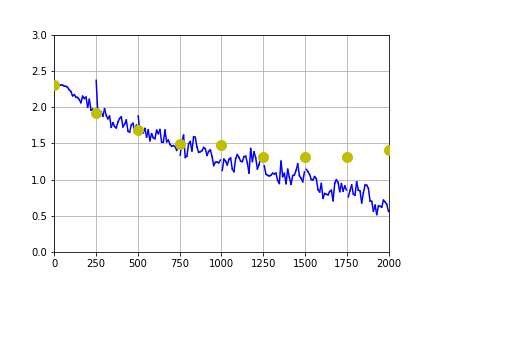

Test loss: 2.3028069160461424
Test accuracy: 0.0774
Step 0
Train loss: 1.9075, learning rate: 0.0065         
Test loss: 1.9146522424697876
Test accuracy: 0.2718
Step 250
Train loss: 1.8230, learning rate: 0.0043         
Test loss: 1.677503427886963
Test accuracy: 0.3621
Step 500
Train loss: 1.4385, learning rate: 0.0030         
Test loss: 1.4944975500106812
Test accuracy: 0.4413
Step 750
Train loss: 1.2236, learning rate: 0.0022         
Test loss: 1.4816617700576782
Test accuracy: 0.462
Step 1000
Train loss: 1.1193, learning rate: 0.0017         
Test loss: 1.3074058436393738
Test accuracy: 0.5251
Step 1250
Train loss: 1.1851, learning rate: 0.0014         
Test loss: 1.316339414691925
Test accuracy: 0.535
Step 1500
Train loss: 0.8794, learning rate: 0.0013         
Test loss: 1.3130927396297454
Test accuracy: 0.5531
Step 1750
Train loss: 0.6821, learning rate: 0.0012         
Test loss: 1.4064274500370026
Test accuracy: 0.5486


In [13]:
if TRAIN:
    # Разрешить интерактивные графики.
    %matplotlib notebook
    seminar.train_model(vgg, make_loss, make_optimizer, trainset_small, testset,
                        lr_scheduler_fn=make_lr_scheduler,
                        **TRAIN_KWARGS)
    # Отключить интерактивные графики.
    %matplotlib inline
else:
    %matplotlib inline
    cvmade.plot.show_image("resources/03-overfit.jpg")

## L2 - регуляризация (Тихонова)

К функции потерь добавляется сумма квадратов параметров модели с некотрым весом (weight decay). В итоге модель штрафуется за слишком большие веса модели. Ограничение на диапазон значений параметров приводит к уменьшению переобучения.

<IPython.core.display.Javascript object>


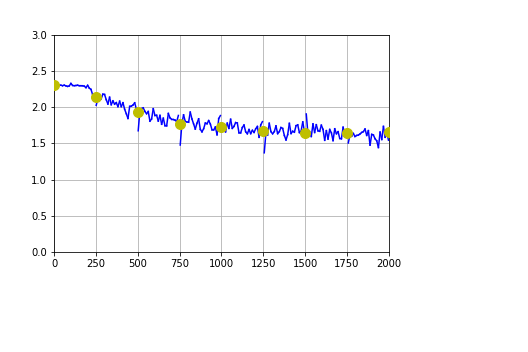

Test loss: 2.302728647994995
Test accuracy: 0.1082
Step 0
Train loss: 2.1153, learning rate: 0.0065         
Test loss: 2.1368522470474245
Test accuracy: 0.1823
Step 250
Train loss: 2.0510, learning rate: 0.0043         
Test loss: 1.9338535903930665
Test accuracy: 0.2775
Step 500
Train loss: 1.8087, learning rate: 0.0030         
Test loss: 1.7713562253952027
Test accuracy: 0.3235
Step 750
Train loss: 1.7716, learning rate: 0.0022         
Test loss: 1.7308987722396851
Test accuracy: 0.3329
Step 1000
Train loss: 1.6902, learning rate: 0.0017         
Test loss: 1.6732235591888427
Test accuracy: 0.3553
Step 1250
Train loss: 1.6541, learning rate: 0.0014         
Test loss: 1.6419206041336059
Test accuracy: 0.3696
Step 1500
Train loss: 1.6674, learning rate: 0.0013         
Test loss: 1.6375769191741942
Test accuracy: 0.3704
Step 1750
Train loss: 1.5065, learning rate: 0.0012         
Test loss: 1.652144349861145
Test accuracy: 0.3673


In [14]:
WEIGHT_DECAY = 0.01

def make_optimizer_l2_reg(model):
    return torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True, weight_decay=WEIGHT_DECAY)

if TRAIN:
    # Разрешить интерактивные графики.
    %matplotlib notebook
    seminar.train_model(vgg, make_loss, make_optimizer_l2_reg, trainset_small, testset,
                        lr_scheduler_fn=make_lr_scheduler,
                        **TRAIN_KWARGS)
    # Отключить интерактивные графики.
    %matplotlib inline
else:
    %matplotlib inline
    cvmade.plot.show_image("resources/04-l2.jpg")

# Dropout

Свертки содержат мало параметров, они не переобучаются. По-этому, dropout обычно используют в полносвязных слоях.

In [15]:
class VGGNetworkDO(VGGNetwork):
    @staticmethod
    def _make_fully_connected(in_features, out_features, last=False):
        layers = [torch.nn.Linear(in_features, out_features)]
        if not last:
            layers.append(torch.nn.Dropout(p=0.85))
        return torch.nn.Sequential(*layers)
    
vgg_do = VGGNetworkDO()
print(vgg_do)
seminar.check_vgg_do(VGGNetworkDO)

VGGNetworkDO(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (14): ReLU()
  (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (16)

<IPython.core.display.Javascript object>


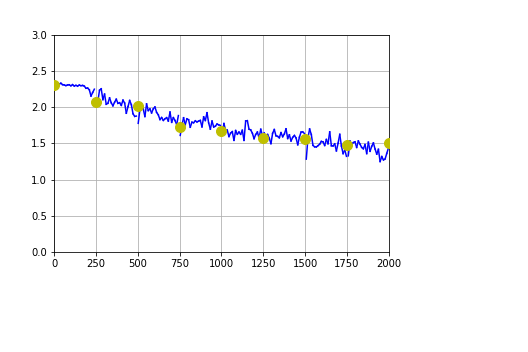

Test loss: 2.3026951915740965
Test accuracy: 0.1001
Step 0
Train loss: 2.1635, learning rate: 0.0065         
Test loss: 2.075055891227722
Test accuracy: 0.2107
Step 250
Train loss: 1.9036, learning rate: 0.0043         
Test loss: 2.016633127403259
Test accuracy: 0.2301
Step 500
Train loss: 1.7037, learning rate: 0.0030         
Test loss: 1.7285464918136597
Test accuracy: 0.3019
Step 750
Train loss: 1.7086, learning rate: 0.0022         
Test loss: 1.673195620918274
Test accuracy: 0.3614
Step 1000
Train loss: 1.6835, learning rate: 0.0017         
Test loss: 1.5721797379493714
Test accuracy: 0.3915
Step 1250
Train loss: 1.5784, learning rate: 0.0014         
Test loss: 1.5600062694549561
Test accuracy: 0.4122
Step 1500
Train loss: 1.3458, learning rate: 0.0013         
Test loss: 1.4764539396286012
Test accuracy: 0.4518
Step 1750
Train loss: 1.3739, learning rate: 0.0012         
Test loss: 1.5010583309173584
Test accuracy: 0.4455


In [16]:
if TRAIN:
    # Разрешить интерактивные графики.
    %matplotlib notebook
    seminar.train_model(vgg_do, make_loss, make_optimizer, trainset_small, testset,
                        lr_scheduler_fn=make_lr_scheduler,
                        **TRAIN_KWARGS)
    # Отключить интерактивные графики.
    %matplotlib inline
else:
    %matplotlib inline
    cvmade.plot.show_image("resources/05-dropout.jpg")

## Аугментация

Мы используем следующие аугментации:
1. Rotation / Scale / Offset
2. Random crop
3. Brightness / Contrast
4. Blur

Шпаргалка:
```python
cv2.getRotationMatrix2D(center, angle, scale)  # center: (x, y), angle: градусы, scale: число.

cv2.warpAffine(src, M, dsize[, dst[, flags[, borderMode[, borderValue]]]])
```

Files already downloaded and verified


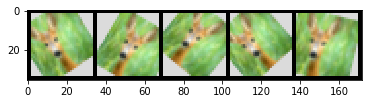

In [17]:
class AffineAugmenter(object):
    def __init__(self, min_scale=0.9, max_scale=1.1, max_offset=0.1):
        self._min_scale = min_scale
        self._max_scale = max_scale
        self._max_offset = max_offset
    
    def __call__(self, image):
        image = np.array(image)  # PIL -> Numpy.
        h, w, c = image.shape
        assert c == 3
        
        angle = random.random() * 90 - 45
        scale = self._min_scale + random.random() * (self._max_scale - self._min_scale)
        x_offset = random.randint(-int(self._max_offset * w), int(self._max_offset * w))
        y_offset = random.randint(-int(self._max_offset * h), int(self._max_offset * h))
        
        # Ваш код, который преобразует изображение используя угол angle,
        # масштаб scale и смещение (x_offset, y_offset). Фон предлагается закрасить серым цветом.
        
        # Начало вашего кода.
        
        transform = 
        
        new_image = 
        
        # Конец вашего кода.
        
        return Image.fromarray(new_image)  # Numpy -> PIL.

  
%matplotlib inline
seminar.show_augmenter_results(AffineAugmenter(), DATA_ROOT)

Пример:
<div style="clear:both;"></div>
<img style="float: left;" src="resources/aug-00-affine.jpg" width="40%" height="40%">
<div style="clear:both;"></div>

Files already downloaded and verified
Trainset size: 5000


<IPython.core.display.Javascript object>


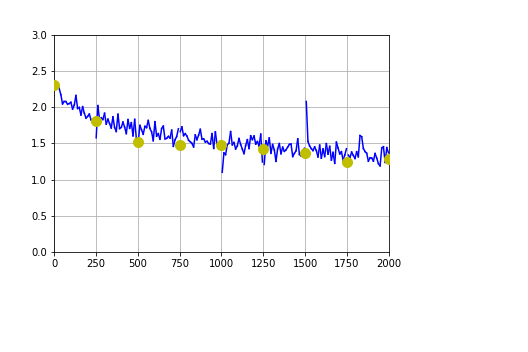

Test loss: 2.302529290008545
Test accuracy: 0.1119
Step 0
Train loss: 1.9091, learning rate: 0.0065         
Test loss: 1.8099443351745605
Test accuracy: 0.3196
Step 250
Train loss: 1.7617, learning rate: 0.0043         
Test loss: 1.5168650597572326
Test accuracy: 0.4186
Step 500
Train loss: 1.7603, learning rate: 0.0030         
Test loss: 1.4818187127113343
Test accuracy: 0.441
Step 750
Train loss: 1.5203, learning rate: 0.0022         
Test loss: 1.4809079363822937
Test accuracy: 0.4738
Step 1000
Train loss: 1.4827, learning rate: 0.0017         
Test loss: 1.420541656112671
Test accuracy: 0.4941
Step 1250
Train loss: 1.3846, learning rate: 0.0014         
Test loss: 1.366095952606201
Test accuracy: 0.5033
Step 1500
Train loss: 1.3477, learning rate: 0.0013         
Test loss: 1.2403213210105897
Test accuracy: 0.5484
Step 1750
Train loss: 1.3642, learning rate: 0.0012         
Test loss: 1.287008134174347
Test accuracy: 0.5362


In [18]:
augmentation_transform = torchvision.transforms.Compose([
    AffineAugmenter(),
    transform
])
trainset_augmented_small = torch.utils.data.Subset(
    CIFAR10(DATA_ROOT, train=True, download=True, transform=augmentation_transform),
    trainset_small_indices)
print("Trainset size:", len(trainset_augmented_small))

if TRAIN:
    # Разрешить интерактивные графики.
    %matplotlib notebook
    seminar.train_model(vgg_bn, make_loss, make_optimizer, trainset_augmented_small, testset,
                        lr_scheduler_fn=make_lr_scheduler,
                        **TRAIN_KWARGS)
    # Отключить интерактивные графики.
    %matplotlib inline
else:
    %matplotlib inline
    cvmade.plot.show_image("resources/07-aug-affine.jpg")

Шпаргалка:
```(python)
cv2.resize(src, dsize[, dst[, fx[, fy[, interpolation]]]])
```

Files already downloaded and verified


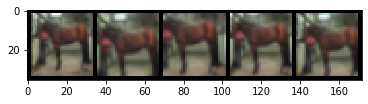

In [22]:
class CropAugmenter(object):
    def __init__(self, min_scale=0.8):
        self._min_scale = min_scale
    
    def __call__(self, image):
        image = np.array(image)  # PIL -> Numpy.
        h, w, c = image.shape
        assert c == 3
        scale = self._min_scale + random.random() * (1 - self._min_scale)
        new_w = int(scale * w)
        new_h = int(scale * h)
        x = random.randint(0, w - new_w)
        y = random.randint(0, h - new_h)
        
        # Ваш код, который создает изображение new_image с фрагментом изображения image, 
        # который задается смещением (x, y) и размером (new_w, new_h).
        
        # Начало вашего кода.
        
        new_image = 
    
        # Конец вашего кода.
        
        return Image.fromarray(new_image)  # Numpy -> PIL.

%matplotlib inline
seminar.show_augmenter_results(CropAugmenter(), DATA_ROOT)

Пример:
<div style="clear:both;"></div>
<img style="float: left;" src="resources/aug-01-crop.jpg" width="40%" height="40%">
<div style="clear:both;"></div>

Files already downloaded and verified


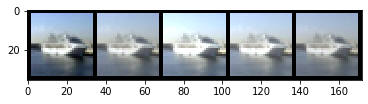

In [19]:
class BrightnessContrastAugmenter(object):
    def __init__(self, brightness=0.3, contrast=0.3):
        self._brightness = brightness
        self._contrast = contrast
    
    def __call__(self, image):
        image = np.array(image)  # PIL -> Numpy.
        h, w, c = image.shape
        assert c == 3
        brightness = 2 * (random.random() - 0.5) * self._brightness
        contrast = 1 + 2 * (random.random() - 0.5) * self._contrast
        
        # Ваш код, который применяет яркость brightness и контраст contrast.
        
        new_image = 
        
        # Конец вашего кода.
        
        assert new_image.dtype == np.uint8
        return Image.fromarray(new_image)  # Numpy -> PIL.
    
%matplotlib inline
seminar.show_augmenter_results(BrightnessContrastAugmenter(), DATA_ROOT)

Пример:
<div style="clear:both;"></div>
<img style="float: left;" src="resources/aug-02-color.jpg" width="40%" height="40%">
<div style="clear:both;"></div>

Шпаргалка:
    
```(python)
cv2.GaussianBlur(src, ksize, sigmaX[, dst[, sigmaY[, borderType]]])  # ksize: (w, h), sigmaX: число.
```

Files already downloaded and verified


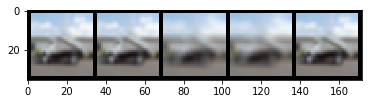

In [20]:
class BlurAugmenter(object):
    def __init__(self, max_kernel=5):
        self._max_kernel = max_kernel
    
    def __call__(self, image):
        kernel = random.randint(0, self._max_kernel // 2) * 2 + 1
        if kernel == 1:
            return image
        image = np.array(image)  # PIL -> Numpy.
        h, w, c = image.shape
        assert c == 3
        
        # Начало вашего кода.
        
        new_image = 
        
        # Конец вашего кода.
        return Image.fromarray(new_image)  # Numpy -> PIL.
    
%matplotlib inline
seminar.show_augmenter_results(BlurAugmenter(), DATA_ROOT)

Пример:
<div style="clear:both;"></div>
<img style="float: left;" src="resources/aug-03-blur.jpg" width="40%" height="40%">
<div style="clear:both;"></div>

Files already downloaded and verified


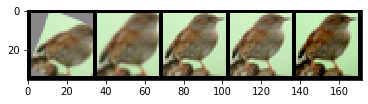

In [46]:
class RandomAugmentation(object):
    def __init__(self, *augmenters):
        self._augmenters = list(augmenters)
        
    def __call__(self, image):
        augmenter = random.choice(self._augmenters)
        return augmenter(image)
    
augmenter = RandomAugmentation(AffineAugmenter(),
                               CropAugmenter(),
                               BrightnessContrastAugmenter(),
                               BlurAugmenter())
%matplotlib inline
seminar.show_augmenter_results(augmenter, DATA_ROOT)

Пример:
<div style="clear:both;"></div>
<img style="float: left;" src="resources/aug-04-random.jpg" width="40%" height="40%">
<div style="clear:both;"></div>

Files already downloaded and verified
Trainset size: 5000


<IPython.core.display.Javascript object>


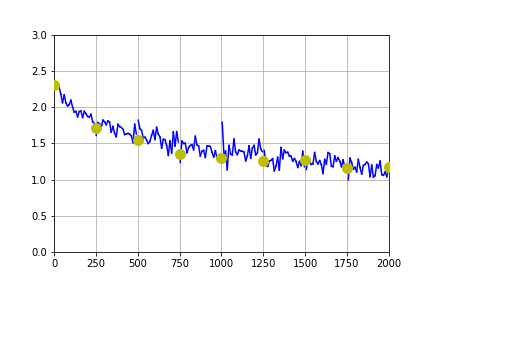

Test loss: 2.3026686008453368
Test accuracy: 0.097
Step 0
Train loss: 1.8724, learning rate: 0.0065         
Test loss: 1.7131567268371581
Test accuracy: 0.3526
Step 250
Train loss: 1.7048, learning rate: 0.0043         
Test loss: 1.545875950717926
Test accuracy: 0.4126
Step 500
Train loss: 1.5191, learning rate: 0.0030         
Test loss: 1.3574836953163147
Test accuracy: 0.506
Step 750
Train loss: 1.3963, learning rate: 0.0022         
Test loss: 1.299869323158264
Test accuracy: 0.5249
Step 1000
Train loss: 1.2981, learning rate: 0.0017         
Test loss: 1.2564143576622009
Test accuracy: 0.5463
Step 1250
Train loss: 1.3874, learning rate: 0.0014         
Test loss: 1.2699374641418457
Test accuracy: 0.5454
Step 1500
Train loss: 1.0767, learning rate: 0.0013         
Test loss: 1.1646833319664
Test accuracy: 0.5834
Step 1750
Train loss: 1.0628, learning rate: 0.0012         
Test loss: 1.1793269690990449
Test accuracy: 0.5805


In [24]:
augmentation_transform = torchvision.transforms.Compose([
    augmenter,
    transform
])
trainset_augmented_small = torch.utils.data.Subset(
    CIFAR10(DATA_ROOT, train=True, download=True, transform=augmentation_transform),
    trainset_small_indices)
print("Trainset size:", len(trainset_augmented_small))

if TRAIN:
    # Разрешить интерактивные графики.
    %matplotlib notebook
    seminar.train_model(vgg_bn, make_loss, make_optimizer, trainset_augmented_small, testset,
                        lr_scheduler_fn=make_lr_scheduler,
                        **TRAIN_KWARGS)
    # Отключить интерактивные графики.
    %matplotlib inline
else:
    %matplotlib inline
    cvmade.plot.show_image("resources/08-aug-all.jpg")

# Albumentations

Большинство стандартных аугментаций уже реализовано

В torchvision классы трансформаций принимают изображение и возвращают изображение.

Классы трансформаций в albumentations принимают kwargs и возвращают словарь. За счёт этого albumentations может обрабатывать и изображения и метки.

albumentations не принимает PIL, нужно конверитровать в Numpy.

Files already downloaded and verified


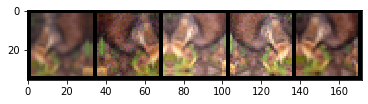

In [123]:
augmenter = albumentations.Compose([
    albumentations.ShiftScaleRotate(rotate_limit=0.25, p=0.7),
    albumentations.RandomBrightnessContrast(p=0.4),
    albumentations.RandomGamma(p=0.4),
    albumentations.Blur(blur_limit=2, p=0.1),
    albumentations.GaussNoise((10, 100), p=0.2),
    albumentations.HorizontalFlip(p=0.5)
])
%matplotlib inline
seminar.show_augmenter_results(lambda image: augmenter(image=np.array(image))["image"], DATA_ROOT)

Files already downloaded and verified
Trainset size: 5000


<IPython.core.display.Javascript object>


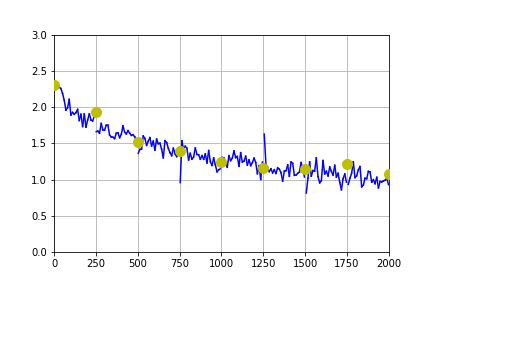

Test loss: 2.3026603157043457
Test accuracy: 0.1
Step 0
Train loss: 1.8449, learning rate: 0.0065         
Test loss: 1.9255543464660645
Test accuracy: 0.2904
Step 250
Train loss: 1.5037, learning rate: 0.0043         
Test loss: 1.5174291585922242
Test accuracy: 0.444
Step 500
Train loss: 1.4583, learning rate: 0.0030         
Test loss: 1.3900525926589966
Test accuracy: 0.4966
Step 750
Train loss: 1.1818, learning rate: 0.0022         
Test loss: 1.2471221638202667
Test accuracy: 0.553
Step 1000
Train loss: 1.1277, learning rate: 0.0017         
Test loss: 1.160134596967697
Test accuracy: 0.5826
Step 1250
Train loss: 1.1761, learning rate: 0.0014         
Test loss: 1.1450529004573822
Test accuracy: 0.5908
Step 1500
Train loss: 1.0858, learning rate: 0.0013         
Test loss: 1.2106416512966156
Test accuracy: 0.5864
Step 1750
Train loss: 0.8116, learning rate: 0.0012         
Test loss: 1.0792990024089812
Test accuracy: 0.6235


In [124]:
augmentation_transform = torchvision.transforms.Compose([
    lambda image: augmenter(image=np.array(image))["image"],
    transform
])

trainset_augmented_small = torch.utils.data.Subset(
    CIFAR10(DATA_ROOT, train=True, download=True, transform=augmentation_transform),
    trainset_small_indices)
print("Trainset size:", len(trainset_augmented_small))

if TRAIN:
    # Разрешить интерактивные графики.
    %matplotlib notebook
    seminar.train_model(vgg_bn, make_loss, make_optimizer, trainset_augmented_small, testset,
                        lr_scheduler_fn=make_lr_scheduler,
                        **TRAIN_KWARGS)
    # Отключить интерактивные графики.
    %matplotlib inline
else:
    %matplotlib inline
    cvmade.plot.show_image("resources/09-aug-album.jpg")